In [1]:
%matplotlib inline
import os
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt


def get_filepath(model, source, only_scores=False):
    labels = None
    if not only_scores:
        labels = os.path.join(data_dir, labels_filename.format(source))
    scores = os.path.join(data_dir, scores_filename.format(model, source))
    return (labels, scores)


def get_label_normalized_scores(model, source, same_file):
    labels_fn, scores_fn = get_filepath(model, source, same_file)
    try:
        if same_file:
            with open(scores_fn, 'rb') as f:
                labels, scores, weights = pkl.load(f)
            scores = np.array(scores) * 2 - 1
        else:
            with open(labels_fn, 'rb') as f:
                labels = pkl.load(f)
            with open(scores_fn, 'rb') as f:
                scores = pkl.load(f)
            weights = np.ones(len(labels))
    except:
        return None
    scores = np.array(scores)
    max_scores, min_scores = np.max(scores), np.min(scores)
    norm = np.max([np.abs(max_scores), np.abs(min_scores)])
    scores = scores / norm
    error = (scores * labels) <= 0
    return np.array(sorted(list(zip(labels, scores, error, weights))))


def get_performance(true, scores):
    # compute auprc
    loss = np.mean(true * -np.log(scores) + (1 - true) * -np.log(1.0 - scores))
    # auroc
    fpr, tpr, _ = roc_curve(true, scores, pos_label=1)
    auroc = auc(fpr, tpr)
    # accuracy
    acc = np.sum(true == (scores > 0.5)) / true.shape[0]
    return (loss, auroc, acc)


def plot_margin(model_id, source_id, case, same_file):
    label_scores = get_label_normalized_scores(sources[model_id], sources[source_id], same_file)
    if label_scores is None:
        return

    counts = np.arange(1, label_scores.shape[0] + 1)
    errors = np.cumsum(label_scores[:, 2])

    '''
    count_perc = counts / label_scores.shape[0]
    overall_error = errors[-1] / label_scores.shape[0]
    if errors[-1] <= 1e-8:
        error_rate = 0.0
    else:
        error_rate = errors / errors[-1]
    '''


    def plot_dash(x, y, ax, frac=10, delta=0.0, color='b', label=None):
        if y[0] > y[-1]:
            y = y[::-1]
            x = x[::-1]
        ret = []
        for i in range(frac):
            t = i / frac
            ret.append(x[np.argmax(y >= t)])
        ret.append(x[-1])
        for i in range(frac):
            t = (i + 1) / frac + delta
            if i == frac - 1:
                ax.plot(sorted([ret[i], ret[i + 1]]), [t, t], c=color, label=label)
            else:
                ax.plot(sorted([ret[i], ret[i + 1]]), [t, t], c=color)


    pos_index = np.argmax(label_scores[:, 0] > 0)
    if label_scores[pos_index, 0] <= 0:
        pos_index = label_scores.shape[0]
    margin_neg = label_scores[:pos_index, 1]
    margin_pos = label_scores[pos_index:, 1]
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    y = 1.0 - np.cumsum(label_scores[pos_index:, 3]) / np.sum(label_scores[pos_index:, 3])  # np.arange(1, margin_pos.shape[0] + 1)[::-1] / (margin_pos.shape[0] + 1)
    # plot_dash(margin_pos, y, ax, label="Positive examples", color='r')
    step = max(1, int(len(y) / 5000))
    ax.plot(margin_pos[::step], y[::step], c='r', label="Positive examples")
    y = np.cumsum(label_scores[:pos_index, 3]) / np.sum(label_scores[:pos_index, 3])  # np.arange(1, margin_neg.shape[0] + 1) / (margin_neg.shape[0] + 1)
    # plot_dash(margin_neg, y, ax, label="Negative examples")
    step = max(1, int(len(y) / 5000))
    ax.plot(margin_neg[::step], y[::step], label="Negative examples")

    ax.grid();
    ax.legend(loc=1);
    ax.axhline(1.0 - pos_index / label_scores.shape[0], ls='--', color="gray");
    ax.set_title("{}\n({})".format(sources[model_id], case));
    ax.set_ylim(-0.01, 1.05)
    ax.set_xlim(-1.05, 1.05);
    ax.set_xlabel("Scores")
    ax.set_ylabel("Percentage of Examples")

    return (fig, ax)

In [2]:
sources = ['AGSO', 'JAMSTEC', 'JAMSTEC2', 'NGA', 'NGDC', 'NOAA_geodas', 'SIO', 'US_multi']

MemoryError: 

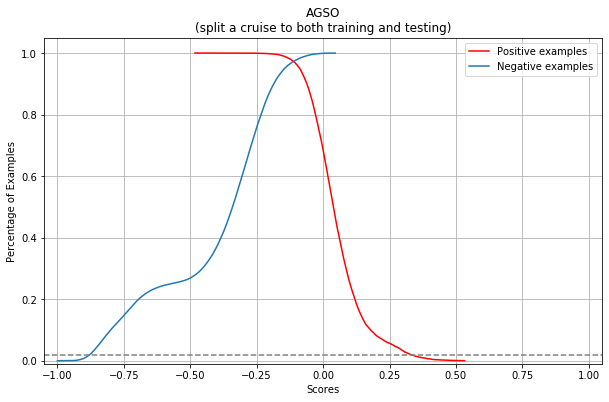

In [3]:
# new
data_dir = "yf-talk-scores/label-leak"
scores_filename = "scores_ms_{}_{}_1"
labels_filename = "labels_{}"
plots = {}
for i, source_id in enumerate(sources):
    plots[source_id] = plot_margin(i, i, "split a cruise to both training and testing", False)

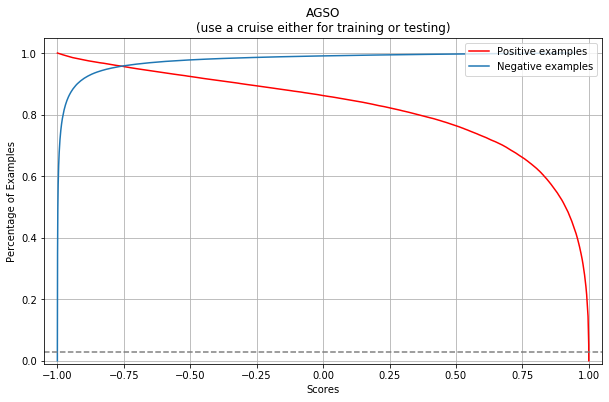

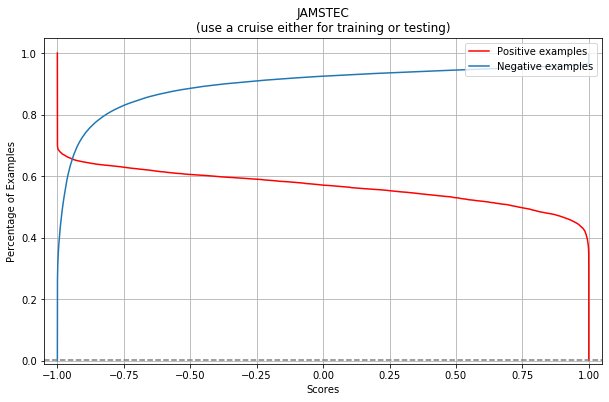

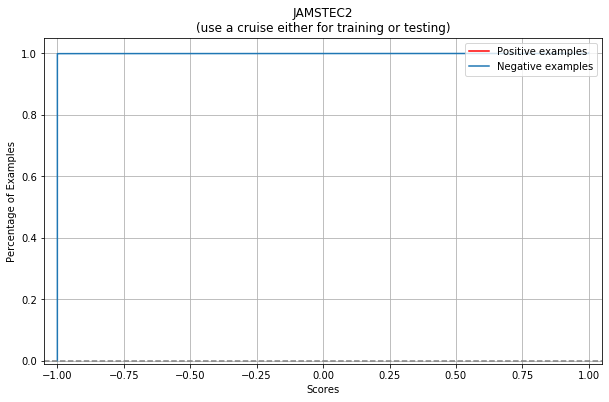

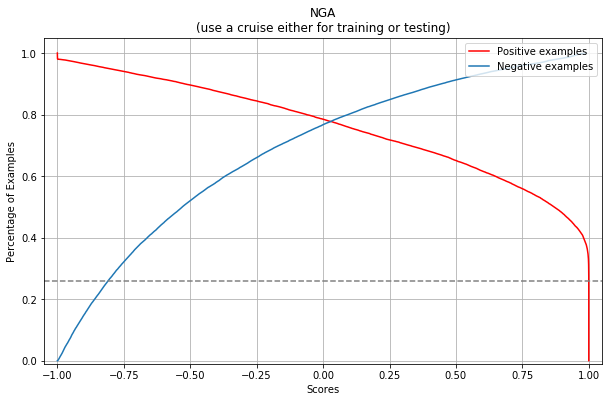

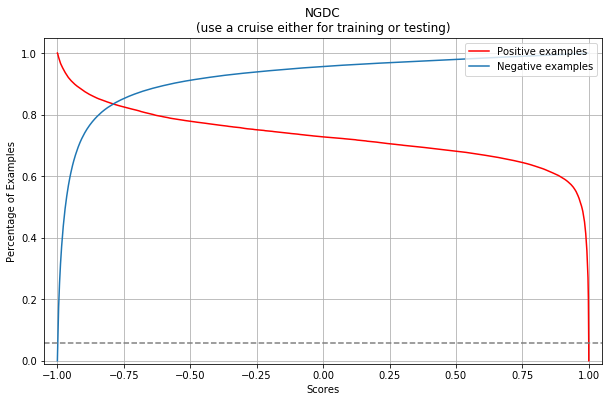

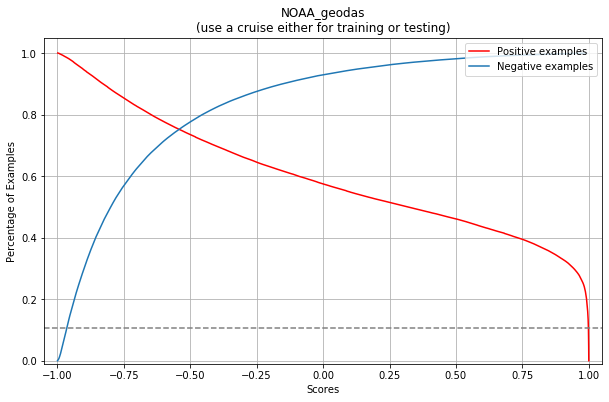

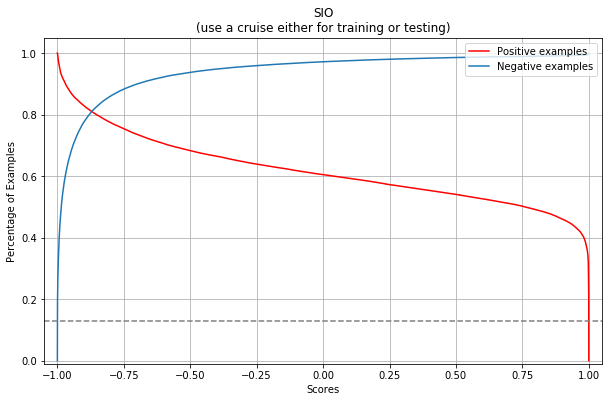

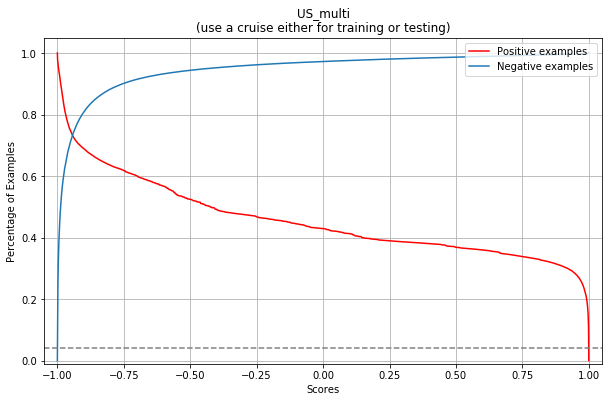

In [3]:
# new
data_dir = "yf-talk-scores/one-source2/"
scores_filename = "testing_result_{}.pkl"
labels_filename = "labels_{}"
plots2 = {}
for i, source_id in enumerate(sources):
    plots2[source_id] = plot_margin(i, i, "use a cruise either for training or testing", True)

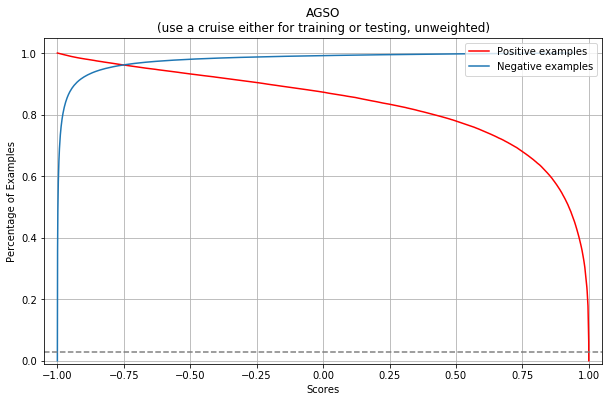

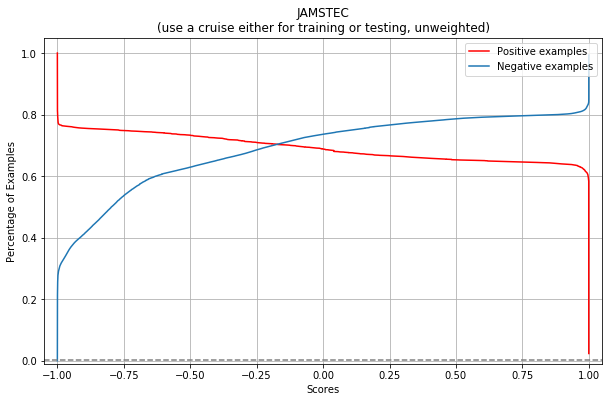

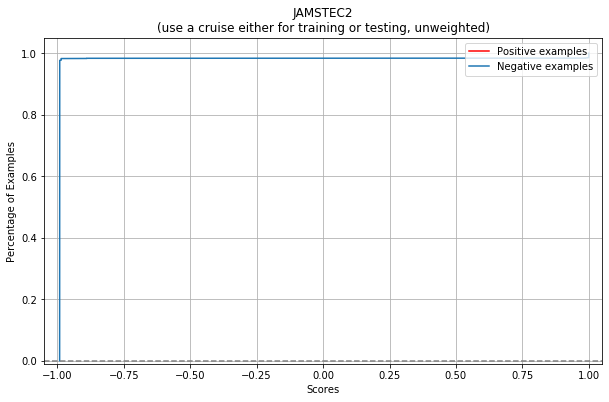

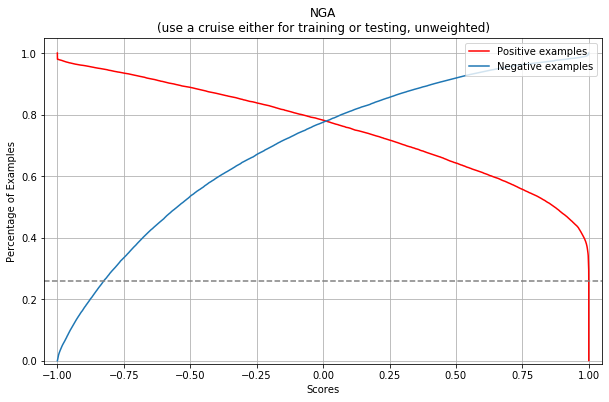

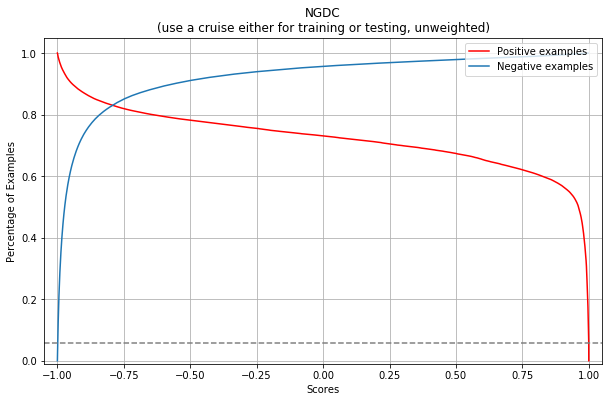

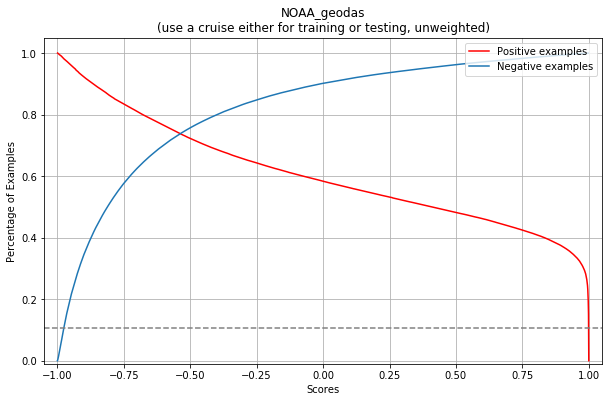

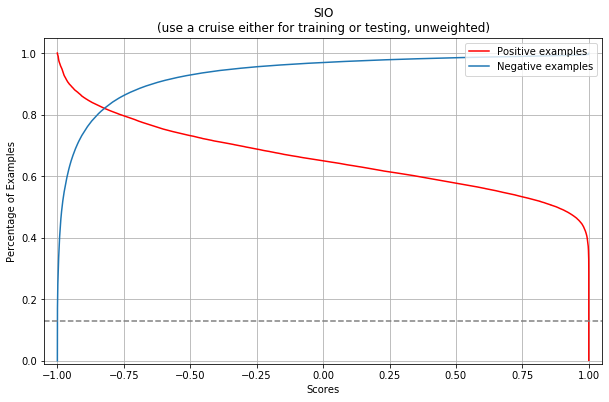

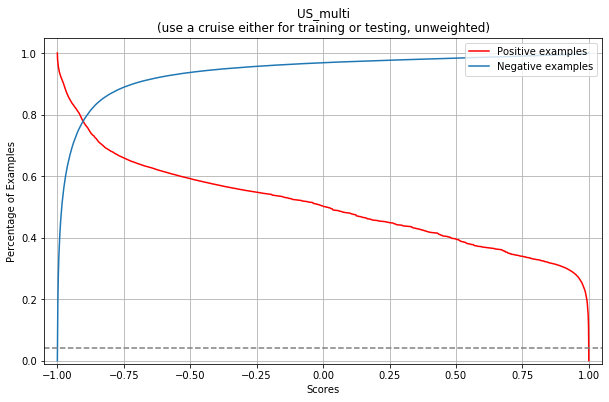

In [4]:
# new
data_dir = "yf-talk-scores/unweighted/"
scores_filename = "testing_result_unweighted_{}.pkl"
labels_filename = "labels_{}"
plots3 = {}
for i, source_id in enumerate(sources):
    plots3[source_id] = plot_margin(i, i, "use a cruise either for training or testing, unweighted", True)